# Ciencia de Datos. TP4: Redes

Axel Maddonni, LU 200/14 <br>
Federico Patane, LU 683/10<br>


*Noviembre 2017*

***

### Creación del Grafo

Leemos el archivo obteniendo los autores de la columna correspondiente, separados por el caracter '&'. Luego de limpiar los strings, generamos todas las combinaciones de pares de autores correspondiente a cada libro y agregamos los ejes al grafo. Para aquellos libros que tengan un sólo autor, agregamos el nodo al grafo en caso de que aún no haya sido agregado. Luego, escribimos el grafo en un archivo.

In [1]:
import networkx as nx
import csv
import itertools
import matplotlib.pylab as plt
import numpy as np
from random import randint
import Queue as queue
import operator

In [2]:
G = nx.Graph()

def cleanData(author):
    author = author.replace(')', '')
    author = author.replace('Inst\.', 'Institute')
    if (author):
        return author

with open('data.csv', 'r') as f:
    reader = csv.reader(f, delimiter=",")
    for row in reader:
        authors = row[3].split("&")
        if (len(authors) == 1):
            G.add_node(authors[0].strip())
        if (len(authors) > 1):
            authors = map(str.strip, authors)
            authors = map(cleanData, authors)
            edges = list(itertools.combinations(authors, 2))
            G.add_edges_from(edges)

nx.write_edgelist(G, 'edgelist.txt')

### Información de nodos y aristas

In [3]:
print nx.info(G)

Name: 
Type: Graph
Number of nodes: 3993
Number of edges: 7856
Average degree:   3.9349


### Representación Gráfica

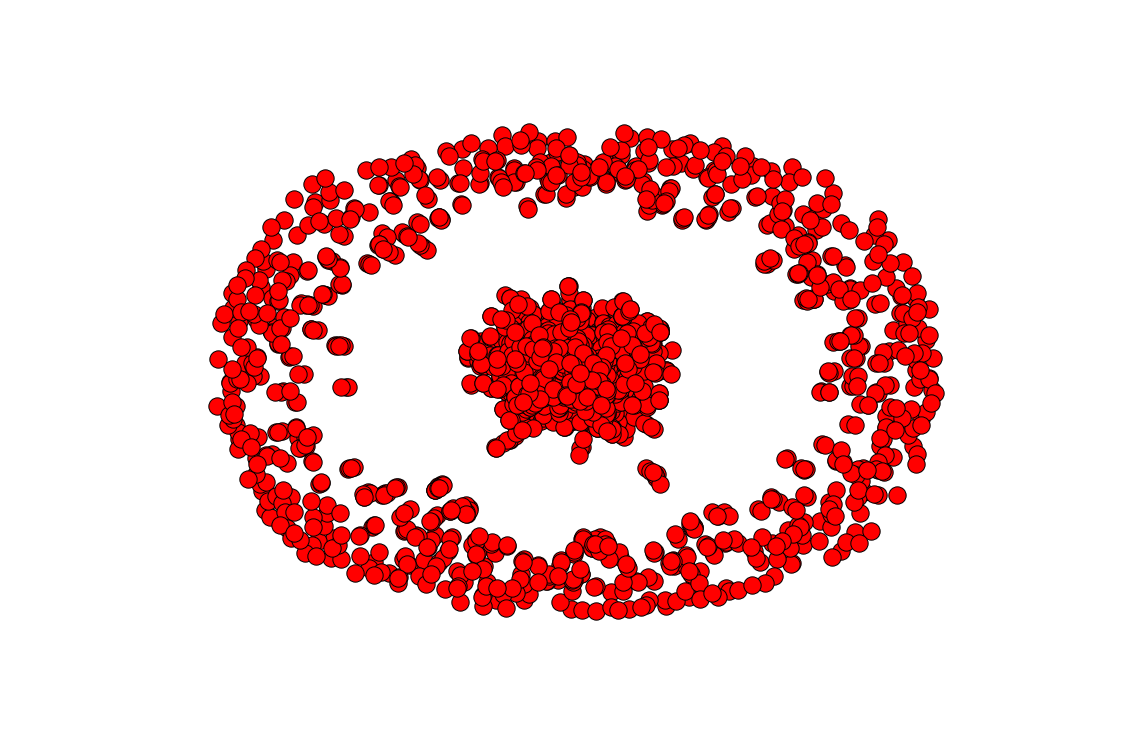

In [4]:
plt.figure(figsize=(15, 10))
nx.draw(G,pos=nx.spring_layout(G)) # use spring layout
plt.show()

### Distribución de Grado

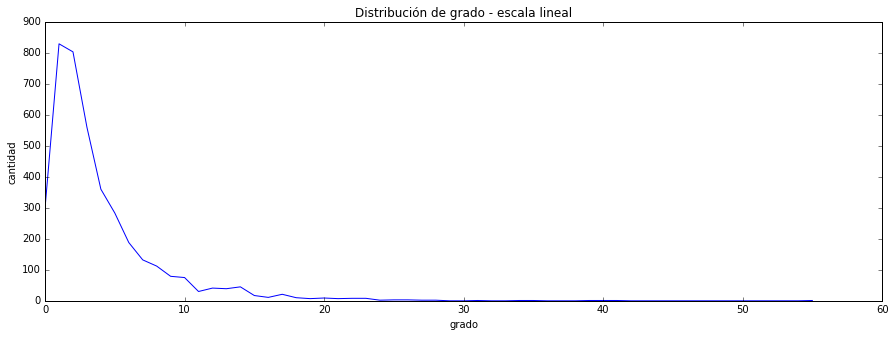

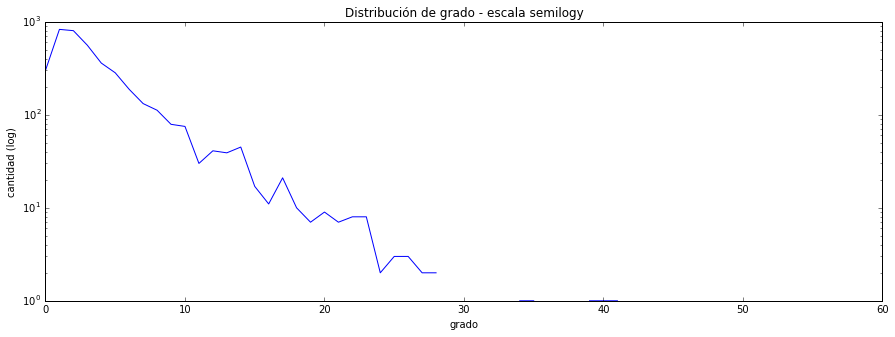

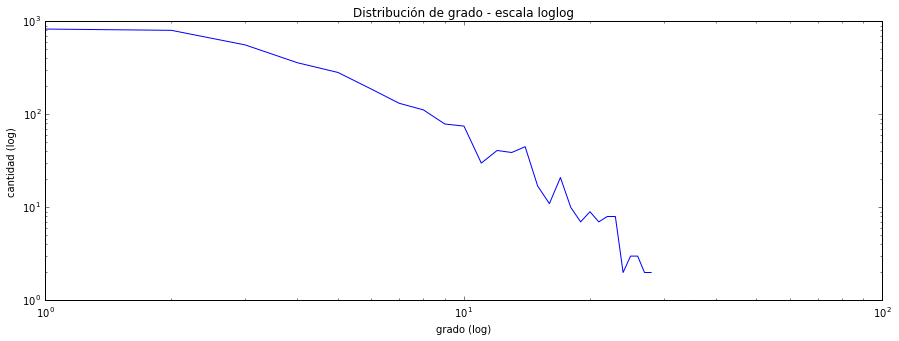

In [5]:
plt.figure(figsize=(15,5))
plt.title(("Distribución de grado - escala lineal").decode('utf-8'))
plt.plot(nx.degree_histogram(G))
plt.xlabel("grado")
plt.ylabel("cantidad")
plt.show()

plt.figure(figsize=(15,5))
plt.title(("Distribución de grado - escala semilogy").decode('utf-8'))
plt.semilogy(nx.degree_histogram(G))
plt.xlabel("grado")
plt.ylabel("cantidad (log)")
plt.show()

plt.figure(figsize=(15,5))
plt.title(("Distribución de grado - escala loglog").decode('utf-8'))
plt.loglog(nx.degree_histogram(G))
plt.xlabel("grado (log)")
plt.ylabel("cantidad (log)")
plt.show()

Observando los tres gráficos, se puede observar cómo en escala semilog se distingue una pendiente lineal, lo que indicaría que se trata de una distribución exponencial de los grados del grafo. Sin embargo, mirando el grafo de escala loglog, también se puede ver una parte (a partir de la mitad del gráfico), que también se asemeja a una lineal, por lo que se trataría de una distribución que se comporta como una exponencial y luego como una ley de potencias.

### Componentes Conexas

In [6]:
print "Número de componentes conexas del grafo: %s" % nx.number_connected_components(G)
largest_cc = max(nx.connected_components(G), key=len)
print "Cantidad de nodos de la máxima componente: %s" % len(largest_cc)

Número de componentes conexas del grafo: 536
Cantidad de nodos de la máxima componente: 3013


### Tamaños de Vecindades

In [7]:
def vecindades(G):
    giant = max(nx.connected_component_subgraphs(G), key=len)
    nodes_from_the_giant_component = [n for n in giant.nodes()]

    dist = 1  
    alcanzados_por_distancia = []
    visited = dict()
    cola = queue.Queue()

    aux = randint(0, len(nodes_from_the_giant_component)-1)
    seed_node = nodes_from_the_giant_component[aux]
    visited[seed_node] = 1
    neighbors_nodes = G.neighbors(seed_node)
    alcanzados_por_distancia.append(1)

    cant = 0
    for neighbor in neighbors_nodes:
        cola.put(neighbor)
        visited[neighbor] = 1
        cant = cant + 1
    alcanzados_por_distancia.append(cant)

    while (len(visited) < len(giant)) :
        nuevos_vecinos = []
        cant = 0
        while (not cola.empty()):
            seed_node = cola.get()
            neighbors_nodes = G.neighbors(seed_node)
            for neighbor in neighbors_nodes:
                if (neighbor not in visited):
                    visited[neighbor] = 1
                    nuevos_vecinos.append(neighbor)
                    cant = cant + 1
        
        alcanzados_por_distancia.append(cant)
        for neighbor in nuevos_vecinos:
            cola.put(neighbor)
        dist = dist + 1

    return alcanzados_por_distancia

agregados_por_distancia = vecindades(G)

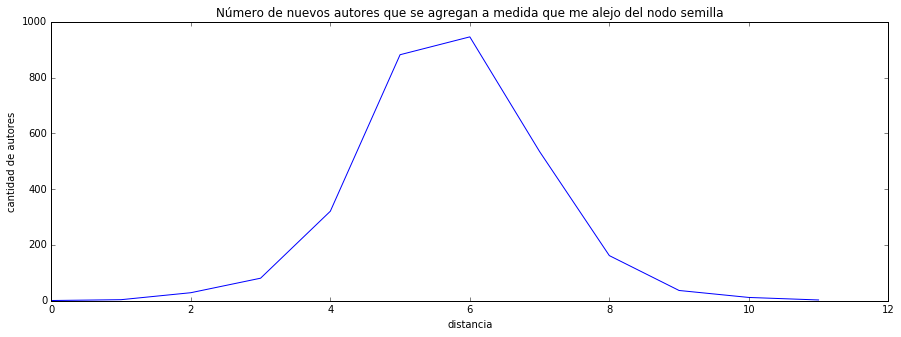

El máximo de la función se alcanza en la distancia 6, donde se alcanzan 946 autores.


In [8]:
plt.figure(figsize=(15, 5))
plt.title(("Número de nuevos autores que se agregan a medida que me alejo del nodo semilla").decode('utf-8'))
plt.plot(agregados_por_distancia)
plt.xlabel("distancia")
plt.ylabel("cantidad de autores")
plt.show()

index, value = max(enumerate(agregados_por_distancia), key=operator.itemgetter(1))
print "El máximo de la función se alcanza en la distancia %i, donde se alcanzan %i autores." % (index, value)

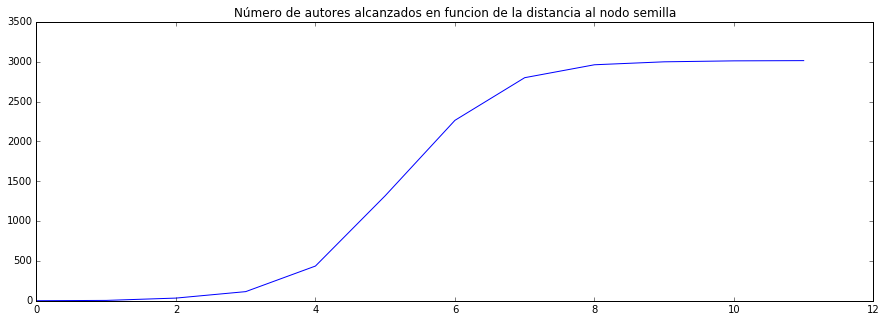

In [9]:
acumulado = 0
alcanzados_por_dist = []
for i in agregados_por_distancia : 
    acumulado = acumulado + i
    alcanzados_por_dist.append(acumulado)

plt.figure(figsize=(15, 5))
plt.title(("Número de autores alcanzados en funcion de la distancia al nodo semilla").decode('utf-8'))
plt.plot(alcanzados_por_dist)
plt.show()

A continuación, ejecutamos el algoritmo varias veces y mostramos los gráficos de los valores promedio que obtenemos, para analizar la robustez del resultado.

In [10]:
resultados = []
for i in xrange(0,30):
    resultados.append(np.array(vecindades(G)))
resultados = np.array(resultados)
min_length = min(map(len, resultados))
resultados = map(lambda l: l[0:min_length], resultados)

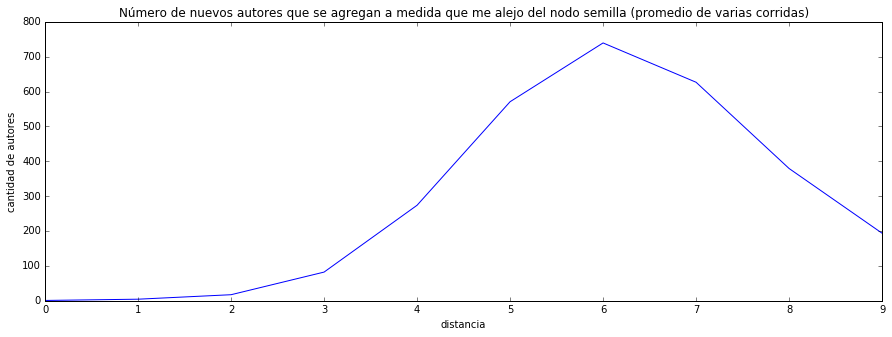

El máximo de la función se alcanza en la distancia 6.


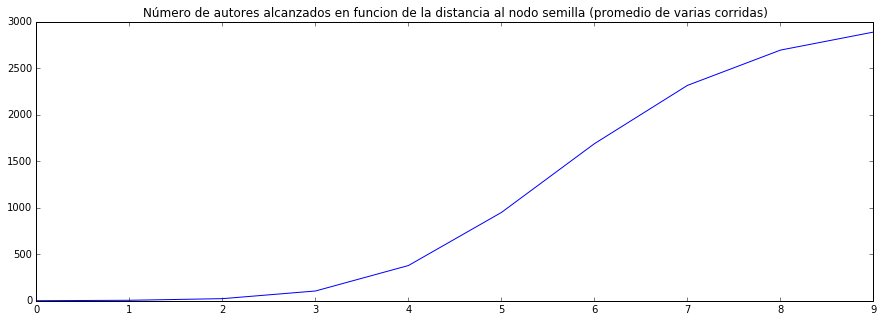

In [11]:
promedios_de_muchos_nodos_semillas =  np.mean(resultados,axis=0)

plt.figure(figsize=(15, 5))
plt.title(("Número de nuevos autores que se agregan a medida que me alejo del nodo semilla (promedio de varias corridas)").decode('utf-8'))
plt.plot(promedios_de_muchos_nodos_semillas)
plt.xlabel("distancia")
plt.ylabel("cantidad de autores")
plt.show()

index, value = max(enumerate(promedios_de_muchos_nodos_semillas), key=operator.itemgetter(1))
print "El máximo de la función se alcanza en la distancia %i." % index

acumulado = 0
alcanzados_por_dist_promedio = []
for i in promedios_de_muchos_nodos_semillas : 
    acumulado = acumulado + i
    alcanzados_por_dist_promedio.append(acumulado)

plt.figure(figsize=(15, 5))
plt.title(("Número de autores alcanzados en funcion de la distancia al nodo semilla (promedio de varias corridas)").decode('utf-8'))
plt.plot(alcanzados_por_dist_promedio)
plt.show()

Los resultados obtenidos en estos gráficos parecen avalar la hipótesis de los seis grados de separación, que intenta probar que cualquiera en la Tierra puede estar conectado a cualquier otra persona del planeta a través de una cadena de conocidos que no tiene más de cinco intermediarios. Dado este grafo de autores, en la componente gigante, en promedio se obtiene que basta con 5 pasos (colaboraciones) hasta llegar a cualquier otro autor en la componente gigante.

Además, con el gráfico de autores alcanzados, se puede ver que con aproximadamente 10 alejamientos del nodo semilla se llega a alcanzar toda la componente gigante.

### Mundos Pequeños

In [12]:
subG_max = G.subgraph(largest_cc)
degree_sequence = [d for n, d in subG_max.degree()]  # degree sequence
random_graph = nx.random_degree_sequence_graph(degree_sequence)
largest_cc_random = max(nx.connected_components(random_graph), key=len)
subG_max_random = random_graph.subgraph(largest_cc_random)

In [13]:
print "Coeficiente de clustering para la componente gigante: %f" % (nx.average_clustering(subG_max, subG_max.nodes()))
print "Camino mínimo medio para la componente gigante: %f" % (nx.average_shortest_path_length(subG_max))

Coeficiente de clustering para la componente gigante: 0.482988
Camino mínimo medio para la componente gigante: 6.097042


In [14]:
print "Coeficiente de clustering para un grafo random: %f" % (nx.average_clustering(subG_max_random, subG_max_random.nodes()))
print "Camino mínimo medio para un grafo random: %f" % (nx.average_shortest_path_length(subG_max_random))

Coeficiente de clustering para un grafo random: 0.003594
Camino mínimo medio para un grafo random: 4.724823


Aclaración: El grafo random mantiene la misma secuencia de grados que el subgrafo de autores con el que estamos trabajando.

Comparando los valores obtenidos para la componente gigante con los obtenidos para el grafo random, se puede ver que el coeficiente de clustering C es mucho mayor en el grafo de autores, al igual que la longitud del camino mínimo medio, lo que indicaría que efectivamente se trata de un grafo con estructura "Mundos Pequeños".

Esto tiene sentido en este contexto, ya que los autores indefectiblemente forman grupos de confianza o trabajo con los que comparten colaboraciones, por lo que se conectan entre sí con "colaboradores de sus colaboradores", formando un grafo más ordenado, y esto produce que en promedio el camino medio para llegar a otro autor sea mayor.

### Estrellas

Para individuar a los autores "estrella" utilizamos las siguientes métricas de centralidad:
1. Degree
2. Closeneess
3. Betweenness

In [15]:
degree_centr = nx.degree_centrality(G)
closeness_centr = nx.closeness_centrality(G)
betw_centr = nx.betweenness_centrality(G)

In [16]:
from IPython.display import HTML, display

def top10 (centr, centrType) :
    top = sorted(centr.iteritems(), key=lambda (k, v): (-v, k))[:10]
    for i, item in enumerate(top):
        top[i] = (i+1, item[0])
    display(HTML(
      '<u>Top by ' + centrType  + ' centrality</u><table><tr>{}</tr></table>'.format(
          '</tr><tr>'.join(
                '<td>{}</td>'.format('</td><td>'.join(str(_) for _ in row)) for row in top)
            )
    ))

top_degree = top10(degree_centr, 'degree')
top_closeness = top10(closeness_centr, 'closeness')
top_betw = top10(betw_centr, 'betwenness')

1,Lee
2,Ambjorn
3,Park
4,Kim
5,Ferrara
6,Vafa
7,Strominger
8,Gibbons
9,Odintsov
10,Lu


1,Lee
2,Vafa
3,Strominger
4,Park
5,Ferrara
6,Kim
7,Lu
8,Polchinski
9,Lowe
10,Peet


1,Lee
2,Kim
3,Ambjorn
4,Vafa
5,Kogan
6,Park
7,Johnson
8,Li
9,Suzuki
10,Gibbons


Mirando los tres top 10 generados por cada métrica, no quedan dudas que el autor estrella es Lee, mientras que el resto del top difiere entre las distintas métricas. Sin embargo, hay algunos autores que permanecen en los 3 tops a la vez, como son: Park, Kim y Vafa (además de Lee) y otros están en dos de los tres tops, como: Ambjorn, Strominger, Gibbons y Lu.

A continuación analizamos cómo disminuye el tamaño de la componente conexa a medida que quitamos los autores top de la misma. Para este ejercicio correremos el algoritmo para cada uno de los tops, y luego para una selección random de autores.

In [17]:
def destruirGrafo (autores_a_eliminar):
    tamanos = []
    i = 0
    largest_cc_aux = max(nx.connected_components(G), key=len)
    subG_aux = nx.Graph(G.subgraph(largest_cc_aux))
    tam_total = len(subG_aux)
    tamanos.append(len(subG_aux) / tam_total)
    while (i < len(autores_a_eliminar) and len(subG_aux) > 0 and (nx.number_connected_components(subG_aux)) > 0 and i < 10000):
        if (autores_a_eliminar[i] in nx.nodes(subG_aux)):
            subG_aux.remove_node(autores_a_eliminar[i])
            if (nx.number_connected_components(subG_aux)) > 0 :
                largest_cc_aux = max(nx.connected_components(subG_aux), key=len)
                subG_aux = nx.Graph(G.subgraph(largest_cc_aux)) 
            tamanos.append(len(subG_aux) / float(tam_total))
        i = i+1
    return tamanos

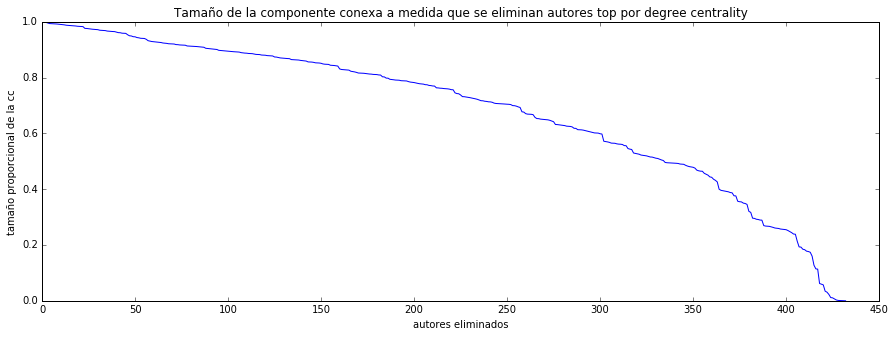

In [18]:
autores_a_eliminar = map(lambda t: t[0], sorted(degree_centr.iteritems(), key=lambda (k, v): (-v, k)))

tamanos = destruirGrafo(autores_a_eliminar)
plt.figure(figsize=(15,5))
plt.title(("Tamaño de la componente conexa a medida que se eliminan autores top por degree centrality").decode('utf-8'))
plt.plot(tamanos)
plt.xlabel("autores eliminados")
plt.ylabel(("tamaño proporcional de la cc").decode('utf-8'))
plt.show()

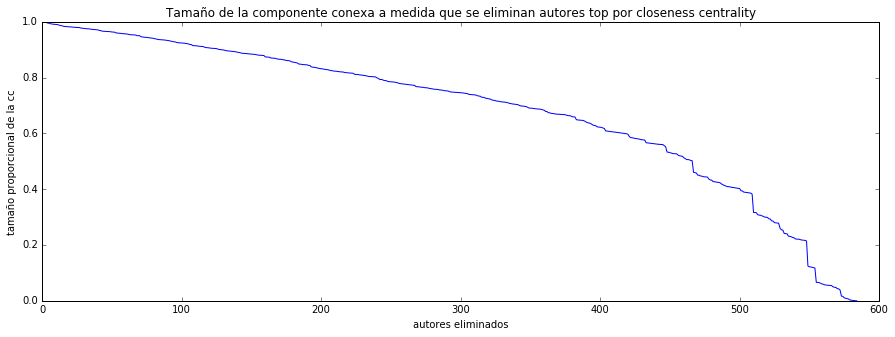

In [19]:
autores_a_eliminar = map(lambda t: t[0], sorted(closeness_centr.iteritems(), key=lambda (k, v): (-v, k)))

tamanos = destruirGrafo(autores_a_eliminar)
plt.figure(figsize=(15,5))
plt.title(("Tamaño de la componente conexa a medida que se eliminan autores top por closeness centrality").decode('utf-8'))
plt.plot(tamanos)
plt.xlabel("autores eliminados")
plt.ylabel(("tamaño proporcional de la cc").decode('utf-8'))
plt.show()

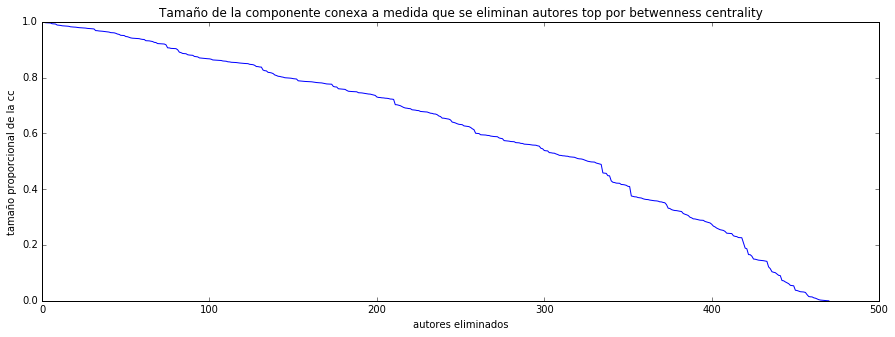

In [20]:
autores_a_eliminar = map(lambda t: t[0], sorted(betw_centr.iteritems(), key=lambda (k, v): (-v, k)))

tamanos = destruirGrafo(autores_a_eliminar)
plt.figure(figsize=(15,5))
plt.title(("Tamaño de la componente conexa a medida que se eliminan autores top por betwenness centrality").decode('utf-8'))
plt.plot(tamanos)
plt.xlabel("autores eliminados")
plt.ylabel(("tamaño proporcional de la cc").decode('utf-8'))
plt.show()

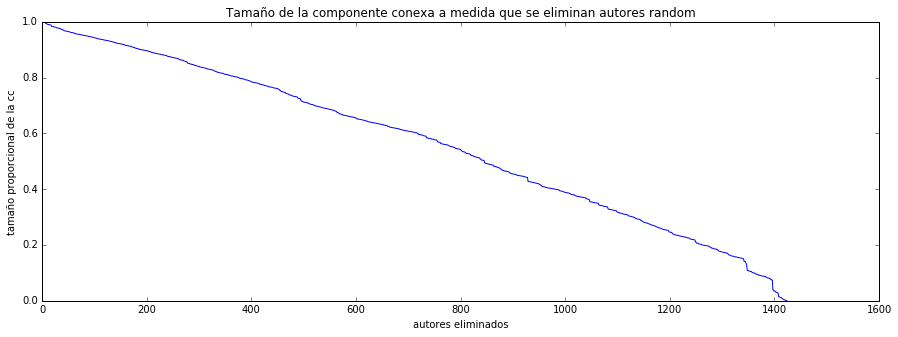

In [21]:
autores_a_eliminar = map(lambda t: t[0], betw_centr.iteritems())

tamanos = destruirGrafo(autores_a_eliminar)
plt.figure(figsize=(15,5))
plt.title(("Tamaño de la componente conexa a medida que se eliminan autores random").decode('utf-8'))
plt.plot(tamanos)
plt.xlabel("autores eliminados")
plt.ylabel(("tamaño proporcional de la cc").decode('utf-8'))
plt.show()

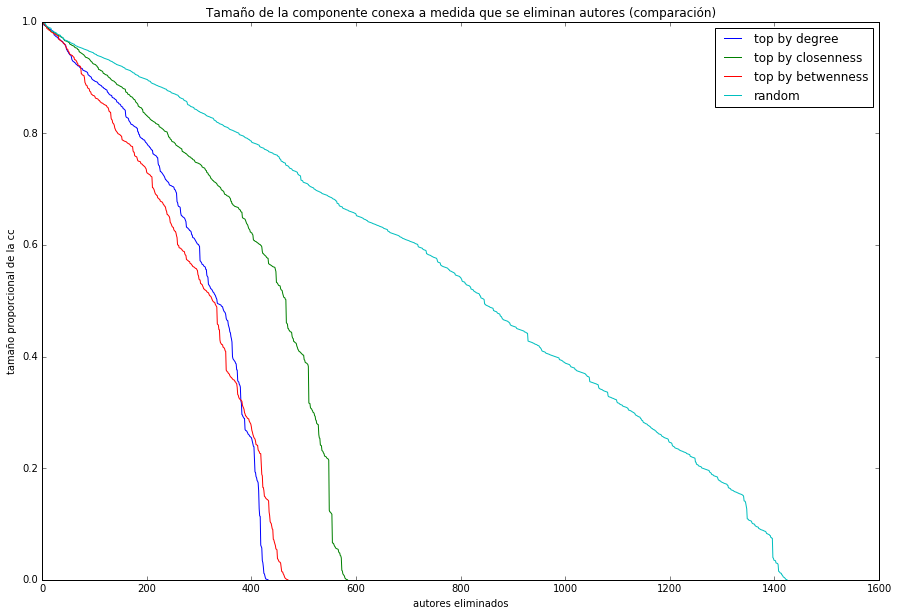

In [22]:
plt.figure(figsize=(15,10))
plt.title(("Tamaño de la componente conexa a medida que se eliminan autores (comparación)").decode('utf-8'))

autores_a_eliminar = map(lambda t: t[0], sorted(degree_centr.iteritems(), key=lambda (k, v): (-v, k)))
tamanos = destruirGrafo(autores_a_eliminar)
plt.plot(tamanos, label="top by degree")

autores_a_eliminar = map(lambda t: t[0], sorted(closeness_centr.iteritems(), key=lambda (k, v): (-v, k)))
tamanos = destruirGrafo(autores_a_eliminar)
plt.plot(tamanos, label="top by closenness")

autores_a_eliminar = map(lambda t: t[0], sorted(betw_centr.iteritems(), key=lambda (k, v): (-v, k)))
tamanos = destruirGrafo(autores_a_eliminar)
plt.plot(tamanos, label="top by betwenness")

autores_a_eliminar = map(lambda t: t[0], betw_centr.iteritems())
tamanos = destruirGrafo(autores_a_eliminar)
plt.plot(tamanos, label="random")

plt.xlabel("autores eliminados")
plt.ylabel(("tamaño proporcional de la cc").decode('utf-8'))
plt.legend(loc='upper right')
plt.show()

Analizando el último gráfico, se puede ver como la componente conexa disminuye de tamaño casi linealmente eliminando autores random, hasta que luego de eliminar aproximadamente la mitad de los nodos originales, la componente desaparece. (ya no hay nodos conectados entre sí)

En los tres gráficos correspondientes al algoritmo eliminando autores tops, se ve una gran diferencia: la componente desaparece luego de eliminar aproximadamente 400-600 autores, mucho menos que al eliminar nodos random. Corresponde a alrededor de 1/6 de los nodos originales de la componente. Esto se debe a que estamos eliminando los nodos más centrales y por ende que aportan mayor conectividad a la componente. Además se puede ver cómo comienza a disminuir linealmente, de manera similar al de autores random, y luego a partir de un punto, el tamaño comienza a disminuir drásticamente.